
## ECOPs AFRICA OCEAN COLOUR TRAINING

### M2-L1: Data manipulation and analysis
<span style="color:brown; font-size:1.2em;font-style:italic">Part 1.2 resampling and temporal composite</span>
<hr style="border:2px solid rgb(30,70,125)"> </hr>


<span style="font-size:1.1em;">Eligio Maure (maure@npec.or.jp)</span>

***
**Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button.   
Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***

# Table of contents
- [1. Purpose](#1.-Purpose)
- [2. Library import](#2.-Library-import)
- [3. Get L2 data from NASA OceanColorWeb](#3.-Get-L2-data-from-NASA-OceanColorWeb)
- [4. Remap and composite](#4.-Remap-and-composite)
- [5. Display the result](#5.-Display-the-result)
- [5. Resources](#5.-Resources)
***

# 1. Purpose
[Return to the "Table of contents"](#Table-of-contents)

In this exercise you will learn to
- reproject a series of swaths images within 8-day time span (M2L1 part 1.1)
- create 8-day composite from the reprojected images 
- visualize the composite (more or less cloud free image)

***

# 2. Library import   

[Return to the "Table of contents"](#Table-of-contents)

Start by importing require modules for this activity   
If a module throws a `ModuleNotFoundError` try installing it with the command  
- `!conda install --channel "conda-forge" module` or with  
- `!pip install module`  

If you have a requirement file containing the names of the modules you want to install, use
- `!pip install -r requirements.txt`

Remove `!` if you run the command directly in your terminal or command prompt.   
For this exercise we created a Python environment using the `environment.yml` file which contains the required module.   
You can also add additional modules to the list.

---

In [1]:
# dateutil
from datetime import datetime

# Data manipulation
import numpy as np
from functools import partial

# System
import sys
from pathlib import Path

# Visualization
from matplotlib import colors, ticker, pyplot as plt
from cartopy import crs as ccrs, feature as cfeature


%matplotlib inline

Matplotlib comes with defaults parameters used for plotting and visualization.   
For example, during instantiation of figures in Matplotlib, often we pass `figsize` parameter to `plt.figure`. <br>
Matplotlib can also be customized to override the default values using rc (runtime configuration) settings.
***

In [2]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['savefig.facecolor'] = '0.8'
# plt.rcParams['figure.constrained_layout.use'] = True

- **Local modules**  

Include a local library (scripts) with custom fuctions.  

We use the `sys` module to append a directory to the list of known paths for interpreter to search.  
This allow us to import the custom functions or modules not in the search directories.

We also use the `Path` library to help us get the name of the current working directory.

---

In [13]:
# appending a path
cwd = Path.cwd()
sys.path.append(str(cwd.parent))

import octutils as util

# 3. Get L2 data from NASA OceanColorWeb

[Return to the "Table of contents"](#Table-of-contents)

We will be using the following parameters for our temporal composite <br>
- Time Period: 8-day period beginning 1 May 2021
- Sensor: MODIS-Aqua
- Area of Interest: region bounded by Lat: 10-30S, and Lon: 30-50E  <br>

We could either use a manifest file or simply fetch data using our `getfile` function.

In [4]:
start = datetime(2021, 5, 1)
end = datetime(2021, 5, 8)
bbox = 7, -35, 20, -25
sensor = 'modisa'
dtype = 'OC' # OC, SST, RRS (nwlr)

In [5]:
# search for a given bbox and time
files = util.getfile(start_date=start, 
                     end_date=end, 
                     bbox=bbox, 
                     sensor=sensor, 
                     dtype=dtype)
print('\n'.join(f'{i+1:02}: {f.name}' for i, f in enumerate(files)))

01: A2021121142500.L2_LAC_OC.nc
02: A2021121124500.L2_LAC_OC.nc
03: A2021121125000.L2_LAC_OC.nc
04: A2021125122000.L2_LAC_OC.nc
05: A2021125122500.L2_LAC_OC.nc
06: A2021125140000.L2_LAC_OC.nc
07: A2021125140500.L2_LAC_OC.nc
08: A2021123124000.L2_LAC_OC.nc
09: A2021124145500.L2_LAC_OC.nc
10: A2021123141500.L2_LAC_OC.nc
11: A2021122133000.L2_LAC_OC.nc
12: A2021127135500.L2_LAC_OC.nc
13: A2021127135000.L2_LAC_OC.nc
14: A2021127121000.L2_LAC_OC.nc
15: A2021124114000.L2_LAC_OC.nc
16: A2021124132000.L2_LAC_OC.nc
17: A2021124114500.L2_LAC_OC.nc
18: A2021123123500.L2_LAC_OC.nc
19: A2021127121500.L2_LAC_OC.nc
20: A2021126130500.L2_LAC_OC.nc
21: A2021126131000.L2_LAC_OC.nc
22: A2021122115500.L2_LAC_OC.nc
23: A2021122115000.L2_LAC_OC.nc
24: A2021122133500.L2_LAC_OC.nc


# 4. Remap and composite

[Return to the "Table of contents"](#Table-of-contents)   

Before we can resample and composite, it is always better to pre-allocate space in memory for efficient processing. The size of pre-allocated array depends on the data tupe, the shape of target projection and the number of files.

In [6]:
def preallocate(shape):
    sds = np.ma.empty(shape, dtype=np.float32)
    sds.mask = True
    return sds

- Preallocation

In [7]:
# resample one file to get the shape and pre-allocate for the rest
# ---------
bits = '11011100110010111101001001000000'
sds, target_geo = util.resample(file=files[0], 
                                flag_bits=bits,
                                key='chlor_a',
                                bbox=bbox)
tot = len(files)
shape = (tot,) + sds.shape
data = preallocate(shape=shape)
data[0, :, :] = np.ma.log10(sds)

Rounding shape to (1107, 1249) and resolution from (1001.0, 1001.0) meters to (1000.4515440909041, 1000.679474676548) meters


A2021121142500.L2_LAC_OC.nc | chlor_a
L2 FLAGS set to mask LAND and EXCLUDE low-quality pixels:
	ATMFAIL: 0
	LAND: 1
	HIGLINT: 3
	HILT: 4
	HISATZEN: 5
	STRAYLIGHT: 8
	CLDICE: 9
	HISOLZEN: 12
	LOWLW: 14
	CHLFAIL: 15
	NAVWARN: 16
	ABSAER: 17
	MAXAERITER: 19
	ATMWARN: 22
	NAVFAIL: 25


- Progress bar function

In [8]:
def progress_bar(file, i, n):
    block = int(50 * i // n)
    bar = '█' * block + '-' * (50 - block)
    percent = f'{(100 * i / n):.1f}'
    status = f'{file.name} | {percent}%'
    print(f'\r{status} |{bar}| {i}/{n}', end='')

- Resample & composite <br>

Since we will resample many files, we can define a partial function with constant parameters and only pass those that need to change, i.e., file name. Since the target spatial map has also been defined I will also use that for reprojection.

In [9]:
func = partial(util.resample,
               flag_bits=bits,
               key='chlor_a', 
               target_geo=target_geo)

In [10]:
%%time

for i, file in enumerate(files[1:]):
    progress_bar(file=file, i=i + 2, n=tot)
    sds = func(file=file) 
    data[i + 1, :, :] = np.ma.log10(sds)

count = data.count(axis=0)
count = np.ma.masked_where(count == 0, count)

mean = data.mean(axis=0).astype(np.float32)
mean = np.ma.power(10, mean)

print(f'\nComposite done!')

A2021122133500.L2_LAC_OC.nc | 100.0% |██████████████████████████████████████████████████| 24/24
Composite done!
Wall time: 2min 6s


# 5. Display the result

[Return to the "Table of contents"](#Table-of-contents)

- Use matplotlib to display the composite image (we display both composite and count)

In [11]:
def imshow(ax, data, norm, label, cmap='nipy_spectral'):
    m = ax.imshow(data, transform=crs, 
              extent=crs.bounds, 
              norm=norm, 
              cmap=cmap, origin='upper')
    ax.coastlines()
    ax.add_feature(cfeature.LAND)

    # Colorbar
    cb = fig.colorbar(m, ax=ax, shrink=0.6, pad=0.01, format='%g')
    cb.set_label(label)

    # map gridlines 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), 
                      draw_labels=True,
                      linewidth=2, 
                      color='gray', alpha=0.5, linestyle=':')
    gl.top_labels  = False
    gl.right_labels = False
    if 'observations' in label:
        gl.left_labels = False

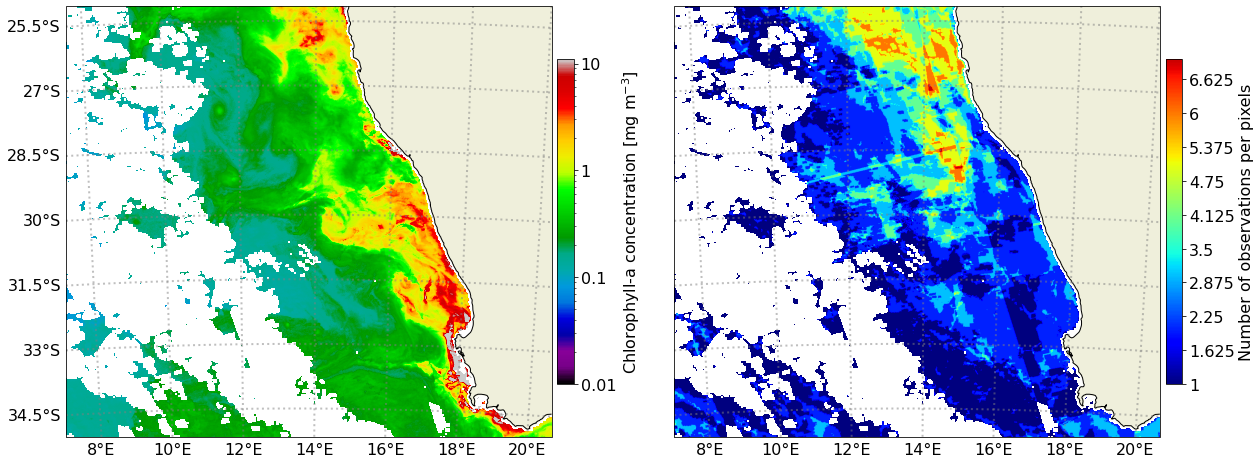

In [12]:
crs = target_geo.to_cartopy_crs()
fig, (ax0, ax1) = plt.subplots(1, 2, subplot_kw={'projection': crs})

# composite map
label = 'Chlorophyll-a concentration [mg m$^{-3}$]'
norm = colors.LogNorm(vmin=0.01, vmax=11)
imshow(ax=ax0, data=mean, norm=norm, label=label)

# count map
label = 'Number of observations per pixels'
levels = ticker.MaxNLocator(nbins=256).tick_values(count.min(), count.max())
norm = colors.BoundaryNorm(boundaries=levels, ncolors=levels.size, clip=True)
imshow(ax=ax1, data=count, norm=norm, label=label, cmap='jet')

plt.tight_layout()

# output file 
file = files[0].parent.joinpath('benguela_composite_chl.png')
fig.savefig(file)

<div class="alert alert-block alert-success"/div>
    <h2>Done!</h2>
  
--- 

#### And thank you for your attention! :) 
    We hope you are enjoying the training provided by A-ECOP for A-ECOPs.

# 6. Resources

[Go back to the "Table of contents"](#Table-of-contents)

1. [PyResample](https://pyresample.readthedocs.io/en/latest/installation.html#)
4. [Matplotlib](https://matplotlib.org/)
5. [Cartopy](https://scitools.org.uk/cartopy/docs/latest/#)
7. [ECOPs Ocean Colour Training](https://github.com/Elgyii/ocean-colour-training-ecops-africa)